In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as linalg
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
d = 2

## Correspondence analysis(CA) - Using Q matrix

(Numerical Ecology, ch9.2) 假设有一个Species丰度矩阵Y，每行代表一个样本，每列代表一个descriptor/feature; **row>=column**

$\begin{gather}Sample 
    \underbrace{\begin{bmatrix}
		...  \\... \\...
		\end{bmatrix}}_{Feature}
\end{gather}$


1. 计算Q: q_ij 是相对频率
    - Q总和=1
    - q_ij >= 0
2. 计算$\overline{Q}$:  $\overline{q_{ij}}=\frac{p_{ij}-p_{i+}p_{+j}}{\sqrt{p_{i+}p_{+j}}} \approx \frac{O_{ij}-E_{ij}}{\sqrt{E_{ij}}}$ 近似 $\chi^2_{ij}$
3. SVD分解：$\overline{Q} = UWV'$


应用：**rare species 对卡方距离的贡献较大！！！** （在原空间的卡方距离==在CA空间的欧氏距离）如果不关注稀有物种，则可以逐步移除它们，关注Eigenvalues的变化

In [2]:
Y = np.matrix([[10,10,20],        ## r=row=i=sample, c=column=j=feature--->ca-axis_d=2
               [10,15,10],
               [15,5,5]])

Y

matrix([[10, 10, 20],
        [10, 15, 10],
        [15,  5,  5]])

In [3]:
Q = Y / Y.sum()
p_j = Q.sum(0)   ## sum of each column  p_+j   Feature 的边缘概率
p_i = Q.sum(1)   ## sum of each row     p_i+   Sample 的边缘概率
Q,p_j,p_i

(matrix([[0.1 , 0.1 , 0.2 ],
         [0.1 , 0.15, 0.1 ],
         [0.15, 0.05, 0.05]]),
 matrix([[0.35, 0.3 , 0.35]]),
 matrix([[0.4 ],
         [0.35],
         [0.25]]))

In [4]:
Q_bar = (Q - p_i @ p_j) / np.sqrt(p_i @ p_j)
Q_bar

matrix([[-0.1069045 , -0.05773503,  0.16035675],
        [-0.06428571,  0.13887301, -0.06428571],
        [ 0.21128856, -0.09128709, -0.12677314]])

In [5]:
Q_tilde = Q / np.sqrt(p_i @ p_j)         ## non-centered Q_bar
Q_tilde

matrix([[0.26726124, 0.28867513, 0.53452248],
        [0.28571429, 0.46291005, 0.28571429],
        [0.50709255, 0.18257419, 0.16903085]])

In [6]:
U, W, V = linalg.svd(Q_bar)             ## U(r×c) W(c×c) V'(c×c)=Q(r×c) ---  U @ np.diag(W) @ V' == Q_bar
U = U[:,:d]                             ## The normalized eigenvectors of (  Q_bar @ Q_bar.T)
W = W[:d]
V = V.T[:,:d]                           ## The normalized eigenvectors of (Q_bar.T @ Q_bar)

U[:,1] = -U[:,1]
V[:,1] = -V[:,1]

U, W, V                                 ##  U(r×2)  W(2×2)  V(c×2) 

(array([[-0.53692695, -0.55830946],
        [-0.1304251 ,  0.79560624],
        [ 0.8334859 , -0.23516219]]),
 array([0.31005325, 0.20234084]),
 array([[ 0.78015766, -0.20335691],
        [-0.20383447,  0.81145025],
        [-0.59144361, -0.54790004]]))

### Scaling type 2

U = $\begin{gather}Sample (Lake1..)
    \underbrace{\begin{bmatrix}
		...  \\... \\...
		\end{bmatrix}}_{\lambda}
\end{gather}$


1. Weight U's each rows by its 1/sqrt(Feature的边缘概率)
2. Freq: normalize Q (Sample的边缘概率=1)

F1 = $\begin{gather}Sample 
    \underbrace{\begin{bmatrix}
		...  \\... \\...
		\end{bmatrix}}_{\lambda}
\end{gather}$  = Weight @ U 

F2 = $\begin{gather}Feature 
    \underbrace{\begin{bmatrix}
		...  \\... \\...
		\end{bmatrix}}_{\lambda}
\end{gather}$  = Freq @ F1 


F1,F2 就是在CA-axis中的坐标


In [7]:
Weight = np.diag(np.array(p_i).squeeze()**(-1/2))          ## D_i^(–1/2)
Freq = np.diag(np.array(p_j).squeeze()**(-1)) @ Q.T   
F1 = Weight @ U                  
F2 = Freq @ Weight @ U           
F1,F2

(array([[-0.84895605, -0.88276476],
        [-0.22045865,  1.34482   ],
        [ 1.6669718 , -0.47032439]]),
 matrix([[ 0.40886943, -0.06955181],
         [-0.11538604,  0.29976768],
         [-0.3099671 , -0.18739192]]))

In [8]:
D = euclidean_distances(np.asarray(F2), np.asarray(F2))    ##   F2中Feature间欧氏距离==原空间chi^2距离
D

array([[0.        , 0.64128051, 0.72843136],
       [0.64128051, 0.        , 0.52458199],
       [0.72843136, 0.52458199, 0.        ]])

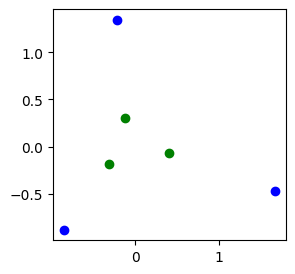

In [9]:
fig=plt.figure(figsize=(3,3))
plt.scatter(np.array(F1[:,0]).squeeze(),np.array(F1[:,1]).squeeze(),c='b')   ## samples: Lake1/2/3
plt.scatter(np.array(F2[:,0]).squeeze(),np.array(F2[:,1]).squeeze(),c='g')   ## features: Spe1/2/3

In [10]:
Fit = np.square(F2) / np.square(F2).sum(1) 
Fit                                                     ## non-Cumulative fit of Feature j: how many variables it explains in each CA-axis

matrix([[0.97187717, 0.02812283],
        [0.12904279, 0.87095721],
        [0.7323401 , 0.2676599 ]])

### Scaling type 1

V = $\begin{gather}Feature (Spe1..)
    \underbrace{\begin{bmatrix}
		...  \\... \\...
		\end{bmatrix}}_{\lambda}
\end{gather}$



1. Weight V's each rows by its 1/sqrt(Sample的边缘概率)
2. Freq: normalize Q (Feature的边缘概率=1)

F1 = $\begin{gather}Feature 
    \underbrace{\begin{bmatrix}
		...  \\... \\...
		\end{bmatrix}}_{\lambda}
\end{gather}$  = Weight @ U 

F2 = $\begin{gather}Sample 
    \underbrace{\begin{bmatrix}
		...  \\... \\...
		\end{bmatrix}}_{\lambda}
\end{gather}$  = Freq @ F1 

F1,F2 就是在CA-axis中的坐标


In [11]:
Weight = np.diag(np.array(p_j).squeeze()**(-1/2))    ## D_j^(–1/2)
Freq = np.diag(np.array(p_i).squeeze()**(-1)) @ Q    ## relative freq within each row: rowsum=1
F1 = Weight @ V                   
F2 = Freq @ Weight @ V           
F1,F2

(array([[ 1.31870712, -0.34373591],
        [-0.37214912,  1.48149869],
        [-0.99972216, -0.92612011]]),
 matrix([[-0.26322158, -0.17861936],
         [-0.06835392,  0.272112  ],
         [ 0.51685002, -0.09516583]]))

In [12]:
D = euclidean_distances(np.asarray(F2), np.asarray(F2))    ##   F2中samples间欧氏距离==原空间chi^2距离
D

array([[0.        , 0.4910521 , 0.78452291],
       [0.4910521 , 0.        , 0.69091002],
       [0.78452291, 0.69091002, 0.        ]])

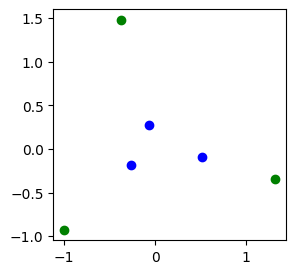

In [13]:
fig=plt.figure(figsize=(3,3))
plt.scatter(np.array(F1[:,0]).squeeze(),np.array(F1[:,1]).squeeze(),c='g')   ## features: Spe1/2/3
plt.scatter(np.array(F2[:,0]).squeeze(),np.array(F2[:,1]).squeeze(),c='b')   ## samples: Lake1/2/3

In [14]:
Fit = np.square(F2) / np.square(F2).sum(1) 
Fit                                                     ## non-Cumulative fit of Sample i: how many variables it explains in each CA-axis

matrix([[0.68470476, 0.31529524],
        [0.05935499, 0.94064501],
        [0.9672091 , 0.0327909 ]])

## DCA

基于各种环境因素，Species中很可能有梯度（unimodal distribution：某物种集中在几个sample/site中，其它site中为0）。CA图像中，这些site点会更加靠近species箭头，图像类似'Arch'

![image.png](./DCA.png)

移除Arch的过程称为detrending：

方法1-----切割某一CA轴，在另一轴上：按区块上下移动点，直至每个区块内点的均值为0

方法2-----（P486，486Fig）在CA算法中，通过施加约束，使II轴与I轴的n次方不相关（species够多且沿梯度相互替换时，II轴类似I轴的二次函数）